In [123]:
# import all required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


seed = 7

In [124]:
# Cross validation framework
def do_cross_validation(X, y, scoring = 'neg_mean_squared_error'):
    models = []
    models.append(('LR', LinearRegression()))
    models.append(('LASSO', Lasso()))
    models.append(('EN', ElasticNet()))
    models.append(('KNN', KNeighborsRegressor()))
    models.append(('CART', DecisionTreeRegressor()))
    models.append(('Ridge', Ridge()))
    #models.append(('SVR', SVR()))
    results_rmse = []
    results_r2 = []
    names = []
    for name, model in models:
        kfold = KFold(n_splits=10, random_state=7)
        cv_results = np.sqrt(-cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring))
        cv_results_r2 = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')
        results_rmse.append(cv_results)
        results_r2.append(cv_results_r2)
        names.append(name)
        msg = "%s: %f (%f) r2: %f (%f)" % \
        (name, cv_results.mean(), cv_results.std(), cv_results_r2.mean(), cv_results_r2.std())
        print(msg)
    return results_rmse, results_r2, names

In [158]:
pisa = pd.read_csv('pisa2009.csv')
print('Shape of data set: ',pisa.shape)

('Shape of data set: ', (5233, 24))


### Impute Missing Values

In [159]:
print('Missing values in data set:', pisa.isnull().sum().sum())


('Missing values in data set:', 4329L)


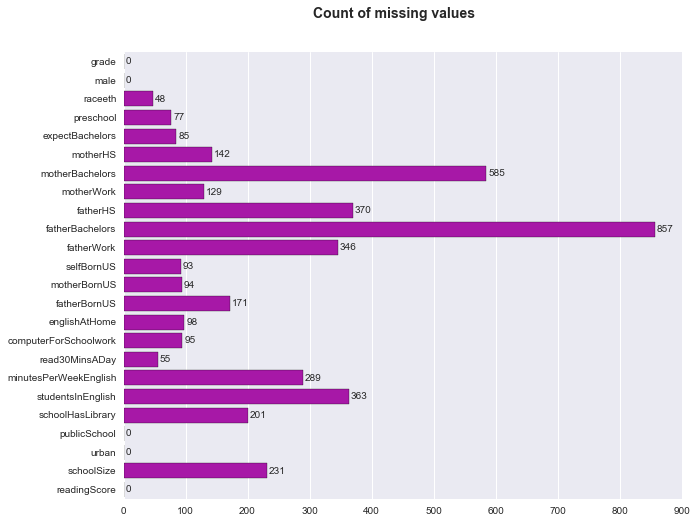

In [161]:
fig = plt.figure(figsize=(10, 8))
fig.suptitle('Count of missing values', fontsize=14, fontweight='bold')
null_data = pisa.isnull().sum()
ax = sns.barplot(x = null_data.values, y=null_data.index, color="m" )
i = 0
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 3, p.get_y() + 0.5, null_data.values[i])
    i += 1

In [127]:
# For continuous variables replace the missing data with average of columns
pisa['minutesPerWeekEnglish'].fillna(int(pisa['minutesPerWeekEnglish'].mean()), inplace=True)
pisa['studentsInEnglish'].fillna(int(pisa['studentsInEnglish'].mean()), inplace=True)
pisa['schoolSize'].fillna(int(pisa['schoolSize'].mean()), inplace=True)

# For 'raceeth' use 'missing' replacement
pisa['raceeth'].fillna('NoRace', inplace=True)
# For binary variable use 0.5 in place of missing value

pisa = pisa.apply(lambda x:x.fillna(0.5))

### Encode categorical values

In [128]:
raceeth = pd.get_dummies(pisa['raceeth'], 'raceeth')
pisa = pd.concat([pisa, raceeth], axis=1)
pisa = pisa.drop('raceeth', axis=1)

### Multi collinearity

In [164]:
# show correlations above 0.5
corr = pisa.corr(method='pearson')
indices = np.where(corr > 0.5)
indices = [(corr.index[x], corr.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]
indices

[('motherHS', 'fatherHS'),
 ('motherBachelors', 'fatherBachelors'),
 ('motherBornUS', 'fatherBornUS'),
 ('motherBornUS', 'englishAtHome'),
 ('fatherBornUS', 'englishAtHome')]

In [165]:
# remove multicolinearity above 0.5, keeping ones with better correlatin with target
# fatherBachelors - keep
# englishAtHome - keep
# motherBachelors - remove
# motherBornUS - remove
# fatherBornUS - remove


pisa = pisa.drop(['motherBachelors','motherBornUS', 'fatherBornUS'], axis=1)

### Transformations

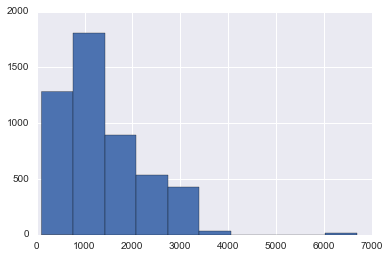

In [166]:
pisa['schoolSize'].hist()

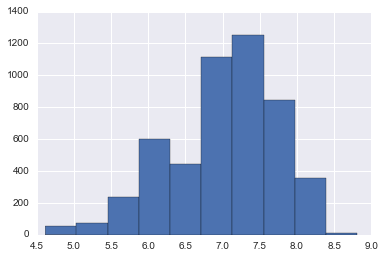

In [169]:
np.log1p(pisa['schoolSize']).hist()

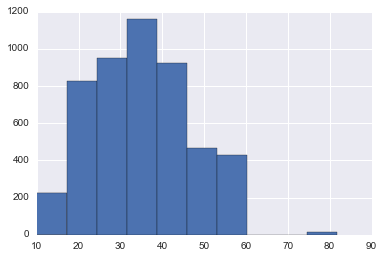

In [173]:
np.sqrt(pisa['schoolSize']).hist()

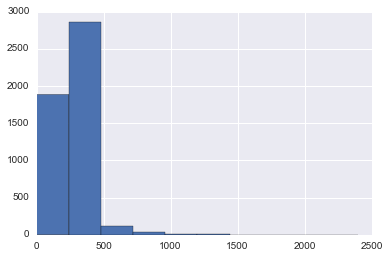

In [168]:
pisa['minutesPerWeekEnglish'].hist()

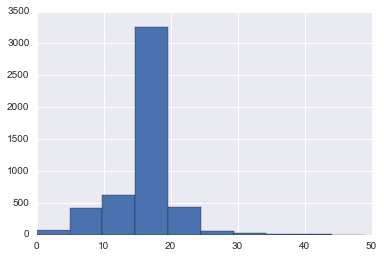

In [171]:
np.sqrt(pisa['minutesPerWeekEnglish']).hist()

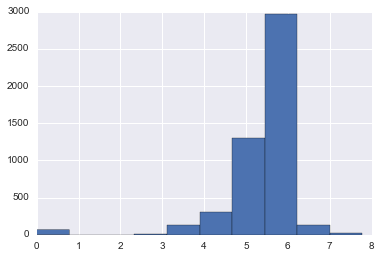

In [172]:
np.log1p(pisa['minutesPerWeekEnglish']).hist()

### Evaluate Algorithms: Baseline

In [129]:
y_train = pisaTrain['readingScore'].values
pisaTrain = pisaTrain.drop('readingScore', axis=1)

In [130]:
X_train = pisaTrain.values
rmse, r2, names = do_cross_validation(X_train, y_train)

LR: 76.233163 (2.007509) r2: 0.359639 (0.040587)
LASSO: 77.037737 (1.520919) r2: 0.346413 (0.031672)
EN: 84.186997 (1.511509) r2: 0.220153 (0.016530)
KNN: 92.449418 (2.142551) r2: 0.059488 (0.030441)
CART: 107.224535 (1.994411) r2: -0.266851 (0.110064)
Ridge: 76.229345 (1.999130) r2: 0.359707 (0.040469)


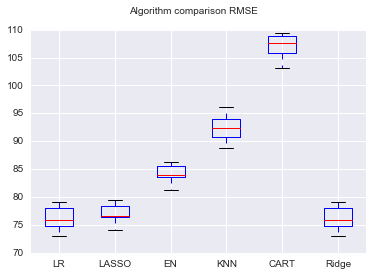

In [131]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm comparison RMSE')
ax = fig.add_subplot(111)
plt.boxplot(rmse)
ax.set_xticklabels(names)
plt.show()

## Data Preparation and Modeling Pipeline

In [132]:
# remove multicolinearity
pisaTrain = pisaTrain.drop(['motherBachelors','motherBornUS', 'fatherBornUS'], axis=1)

In [133]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

In [134]:
scaler = MinMaxScaler(feature_range=(0,1))
rescaledX = scaler.fit_transform(X_train)
_ = do_cross_validation(rescaledX, y_train)


LR: 76.233163 (2.007509) r2: 0.359639 (0.040587)
LASSO: 77.037737 (1.520919) r2: 0.346413 (0.031672)
EN: 84.186997 (1.511509) r2: 0.220153 (0.016530)
KNN: 92.449418 (2.142551) r2: 0.059488 (0.030441)
CART: 106.553735 (2.550560) r2: -0.242519 (0.083073)
Ridge: 76.229345 (1.999130) r2: 0.359707 (0.040469)


In [135]:
scaler = StandardScaler()
rescaledX = scaler.fit_transform(X_train)
_ = do_cross_validation(rescaledX, y_train)

LR: 76.233163 (2.007509) r2: 0.359639 (0.040587)
LASSO: 77.037737 (1.520919) r2: 0.346413 (0.031672)
EN: 84.186997 (1.511509) r2: 0.220153 (0.016530)
KNN: 92.449418 (2.142551) r2: 0.059488 (0.030441)
CART: 106.294389 (2.856093) r2: -0.265162 (0.091381)
Ridge: 76.229345 (1.999130) r2: 0.359707 (0.040469)


In [136]:
scaler = Normalizer()
rescaledX = scaler.fit_transform(X_train)
_ = do_cross_validation(rescaledX, y_train)

LR: 76.233163 (2.007509) r2: 0.359639 (0.040587)
LASSO: 77.037737 (1.520919) r2: 0.346413 (0.031672)
EN: 84.186997 (1.511509) r2: 0.220153 (0.016530)
KNN: 92.449418 (2.142551) r2: 0.059488 (0.030441)
CART: 107.110093 (3.134743) r2: -0.268529 (0.094255)
Ridge: 76.229345 (1.999130) r2: 0.359707 (0.040469)


In [137]:
# create pipeline
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('LR', LinearRegression()))
model = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=7)
results = np.sqrt(-cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error'))
print(results.mean())

76.2263128012


## Feature Selection

### Multicollinearity

In [163]:
# correlation
df = pisaTrain
df['readingScore']=y_train
corDf = df.corr(method='pearson')
corDf

ValueError: Length of values does not match length of index

In [162]:
indices = np.where(corDf > 0.5)
indices = [(corDf.index[x], corDf.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]
indices

[]

In [140]:
#remove 'motherBachelors','motherBornUS', 'fatherBornUS'
